In [0]:
import os
import io
import pickle
import requests
import zipfile
import numpy as np
from scipy import ndimage
from skimage.transform import resize
from imageio import imread, imsave
from skimage import img_as_float, color, exposure
from skimage.feature import peak_local_max, hog
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.svm import LinearSVC
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
r = requests.get('https://github.com/wOOL/COM2028/raw/master/W7/datasets1.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

r = requests.get('https://github.com/wOOL/COM2028/raw/master/W7/datasets2.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

# A. Building, Mountain or Highway? - Classification using SVM

## Extracting features from images
Understanding the context of an image can be a very difficult task, but it is an extremely active research area due to limitless possible applications. For example, consider the following problem: how can a service such as Flickr or Instagram identify images without any manual labelling? Millions of images are uploaded each year so a non-automated method cannot be the answer. Consider a simple application: an automated recommendation machine. If we find out that a user takes a lot of car photos, then it would be a good idea to provide him with further relevant information. Similar techniques are used for brand analysis, face detection, object detection etc. 

### Edge detection
Edge detection is one of the most important methods in image processing, as it can extract valuable information on the nature of the image, and the nature of the objects of the image. The Sobel method for edge detection uses two convolution masks of size [3,3]. The masks are:

\begin{equation*} 
G_x=
\begin{pmatrix}
-1 & 0 & 1\\
-2 & 0 & 2\\
-1 & 0 & 1\\
\end{pmatrix}
\end{equation*} 

\begin{equation*} 
G_y=
\begin{pmatrix}
-1 & -2 & -1\\
0 & 0 & 0\\
1 & 2 & 1\\
\end{pmatrix}
\end{equation*} 

If you look at these kernels, you will see that $G_x$ is designed to highlight changes in the $x$ direction, and $G_y$ is designed to highlight changed in the $y$ direction. By changed we mean a rapid increase or decrease in the image intensity. 

If we apply these two convolution masks to the image, we will get two new images $I_x$ and $I_y$. $I_x$ is dark where there are no sudden changed in the image intensity along the $x$ axis, and bright where there are. The same applies for the $y$ image. 

We can combine these two images, to form a general edge image we use the following formula.

\begin{equation}
\label{equation:edges}
E(x,y) = \sqrt{I_x^2(x,y)+ I_y^2(x,y)}
\end{equation}

In order to make the computation faster, we can also use the simplest approximation to the equation above $\hat{E} = I_x+I_y$


In [0]:
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [0]:
lena = imread('./datasets/img/lena_gray.png')
lena = lena.astype(np.float32)
(w,h) = lena.shape

In [0]:
sobelx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
sobely = np.array([[-1, -2, -1],
                   [0, 0, 0],
                   [1, 2, 1]])

convolutedx = np.empty_like(lena)
convolutedy = np.empty_like(lena)
convolutedhat = np.empty_like(lena)
convoluted = np.empty_like(lena)

In [0]:
#slow unoptimzed code
for x in range(1,w-1):
    for y in range(2,h-1):
        convolutedx[x,y] = sobelx[0,0]* lena[x-1,y-1] + sobelx[0,1]* lena[x-1,y] + sobelx[0,2]* lena[x-1,y+1] + sobelx[1,0]* lena[x,y-1] + sobelx[1,1]* lena[x,y] + sobelx[1,2]* lena[x,y+1] + sobelx[2,0]* lena[x+1,y-1] + sobelx[2,1]* lena[x+1,y]+ sobelx[2,2]* lena[x+1,y+1]
        convolutedy[x,y] = sobely[0,0]* lena[x-1,y-1] + sobely[0,1]* lena[x-1,y] + sobely[0,2]* lena[x-1,y+1] + sobely[1,0]* lena[x,y-1] + sobely[1,1]* lena[x,y] + sobely[1,2]* lena[x,y+1] + sobely[2,0]* lena[x+1,y-1] + sobely[2,1]* lena[x+1,y]+ sobely[2,2]* lena[x+1,y+1]

#fix the overflows
convolutedx[convolutedx>255]=255
convolutedx[convolutedx<0]=0
convolutedy[convolutedy>255]=255
convolutedy[convolutedy<0]=0

#combine
convolutedhat = convolutedx + convolutedy
convoluted = np.sqrt(np.power(convolutedx,2)+np.power(convolutedy,2))

#fix the overflows
convolutedhat[convolutedhat>255]=255
convolutedhat[convolutedhat<0]=0

#fix the overflows
convoluted[convoluted>255]=255
convoluted[convoluted<0]=0

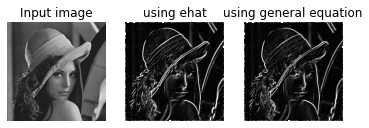

In [27]:
#show the image
plt.subplot(131).set_axis_off()
plt.imshow(lena, cmap=plt.cm.gray)
plt.title('Input image')

#show the result
plt.subplot(132).set_axis_off()
plt.imshow(convolutedhat, cmap=plt.cm.gray)
plt.title('using ehat')
#plt.show()

#show the result
plt.subplot(133).set_axis_off()
plt.imshow(convoluted, cmap=plt.cm.gray)
plt.title('using general equation')
plt.show()

### Corner detection

When we want to extract features from an image, we want to identify the points that are **interesting**. Interesting in terms of the feature analysis, means to detect strong points, that stand out from the points around them. The easiest way to do that, it to identify the corners in the image. Corners are strongly related to the edges, but while the edge represents a change in the intensity around a specific direction, the corner detection tries to identify points where the intensity changes in all the directions around.

The simplest and most common way to uses the notion of the Hessian matrix around a point $x,y$, which is defined as 

\begin{equation}
\label{equation:harris}
H_{x,y} =
 \begin{bmatrix}
  \dfrac{\partial^2 I(x,y)}{\partial x^2} & \dfrac{\partial^2 I(x,y)}{\partial x \partial y} \\ 
  \dfrac{\partial^2 I(x,y)}{\partial y \partial x} & \dfrac{\partial^2 I(x,y)}{\partial y^2}
 \end{bmatrix}
\end{equation}

Of course the partial derivatives in the discrete 2D image space, are translated to differences around points. We can get these differences using the edge convolution masks that were introduced above. We now consider the matrix $\hat{H}=w*H_{x,y}$ where w is a Gaussian mask. The nature of the eigenvalues of $\hat{H}$ around the point $(x,y)$ gives us information on the distribution of the intensity pixels.


There are three possible combinations for the two eigenvalues of $\hat{H}$ $\lambda_1 \text{ and } \lambda_2$:


* $\lambda_1$ large, and $\lambda_2$ large $\rightarrow$ $(x,y)$ is a corner
* $\lambda_1$ large, and $\lambda_2 \approx 0$ $\rightarrow$ $(x,y)$ is an edge
* $\lambda_1 \approx 0 $, and $\lambda_2 \approx 0$ $\rightarrow$ $(x,y)$ is not interesting


In order to identify the first case, without having to compute the eigenvalues:

\begin{equation}
\label{equation:corners_matrix}
c_{(x,y)}= \dfrac{det(\hat{H})}{trace(\hat{H})^2} 
\end{equation}

Computing the value $c_{(x,y)}$ for all the pixels of the image, gives a new array $C$, which holds the information on corners. High values in that $C$ array, are indicators of corners. Scipy provides all the neccessary method to inverse matrices, compute the $det$ and the $trace$, together with many more methods for linear algebra. You don't have to know everything, the important part is to know how to use them.

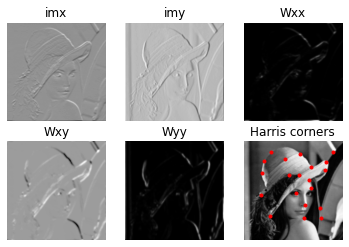

In [28]:
image = imread('./datasets/img/lena_gray.png')/255.0
image = img_as_float(image)

#Harris corner detection part#
#Adapted form the scikits-image implementation of the harris detector#
eps=1e-6
gaussian_deviation=1
min_distance=20
threshold=0.1
# derivatives
image = ndimage.gaussian_filter(image, gaussian_deviation)
imx = ndimage.sobel(image, axis=0, mode='constant')
imy = ndimage.sobel(image, axis=1, mode='constant')

Wxx = ndimage.gaussian_filter(imx * imx, 1.5, mode='constant')
Wxy = ndimage.gaussian_filter(imx * imy, 1.5, mode='constant')
Wyy = ndimage.gaussian_filter(imy * imy, 1.5, mode='constant')

# determinant and trace
Wdet = Wxx * Wyy - Wxy ** 2
Wtr = Wxx + Wyy
# Alternate formula for Harris response.
# Alison Noble, "Descriptions of Image Surfaces", PhD thesis (1989)
harris = Wdet / (Wtr + eps)
coordinates = peak_local_max(harris, min_distance=min_distance)
#End of Harris corner detection part#

#show some results
plt.subplot(231, aspect='equal')
plt.imshow(imx, cmap=plt.cm.Greys_r,aspect='equal')
plt.title('imx')
plt.axis('off')

plt.subplot(232, aspect='equal')
plt.imshow(imy, cmap=plt.cm.Greys_r,aspect='equal')
plt.title('imy')
plt.axis('off')

plt.subplot(233, aspect='equal')
plt.imshow(Wxx, cmap=plt.cm.Greys_r,aspect='equal')
plt.title('Wxx')
plt.axis('off')

plt.subplot(234, aspect='equal')
plt.imshow(Wxy, cmap=plt.cm.Greys_r,aspect='equal')
plt.title('Wxy')
plt.axis('off')

plt.subplot(235, aspect='equal')
plt.imshow(Wyy, cmap=plt.cm.Greys_r,aspect='equal')
plt.title('Wyy')
plt.axis('off')


plt.subplot(236, aspect='equal')
plt.imshow(image,cmap=plt.cm.Greys_r,aspect='equal')
y, x = np.transpose(coordinates)
plt.plot(x, y, 'r.')
plt.axis('off')
plt.title('Harris corners')

plt.show()

### Descriptive image features 

This section introduces some details on how to work with high level image descriptors. This is an important section, because through the lab, we will use such features in order to classify, cluster, identify or distinguish images. Descriptors like that, are normally a vector of specific size $n$ $f = [f_1, f_2...,f_n]$. These can also be called features of the images, because they are collections of numbers that represent the structure of the images. 


**SIFT** : One of the most important features proposed in the previous years was proposed by David Lowe. The SIFT descriptor that was described in this paper, is very robust to scale, intensity or rotational changes, and it is a great tool when building image and video applications. You dont need to know all the details of the method, but it is good to know that the method detects the dominant gradient orientation at its location and records its local gradient histogram results with respect to this orientation. There are many more similar features that can be used, but the original SIFT method is protected by a patent, so many times when developers want to build an application they use different features.

**HOG**:
We will investigate how to use the **HOG** feature vector together with a new type of classifier, support vector machine (**SVM**), in order to build a system that can automatically identify if a query image depicts a mountain, a city or a highway.  The main idea behind the HOG descriptor is to quantify the distribution of the orientation edges in all the points of the image. The size of  the hog feature vectoris controlled by some parameters like the number of the orientation, or the number of blocks per image. These factors can be changed in the implementation we will use, the one provided by **scikits-image**.


In [29]:
#paths for the training samples 
path_buildings = './datasets/SVM/training/buildings/'
path_mountain = './datasets/SVM/training/mountain/'
path_highway = './datasets/SVM/training/highway/'

#get all the images in the above folders
#note that we are looking for specific extensions (jpg, bmp and png)
building_filenames = sorted([filename for filename in os.listdir(path_buildings) if (filename.endswith('.jpg') or filename.endswith('.png') or (filename.endswith('.bmp'))) ])
mountain_filenames = sorted([filename for filename in os.listdir(path_mountain) if (filename.endswith('.jpg') or filename.endswith('.png') or (filename.endswith('.bmp'))) ])
highway_filenames = sorted([filename for filename in os.listdir(path_highway) if (filename.endswith('.jpg') or filename.endswith('.png') or (filename.endswith('.bmp'))) ])

#add the full path to all the filenames
building_filenames = [path_buildings+filename for filename in building_filenames]
mountain_filenames = [path_mountain+filename for filename in mountain_filenames]
highway_filenames = [path_highway+filename for filename in highway_filenames]

print('Number of training images -> buildings: ' + str(len(building_filenames)))
print('Number of training images -> mountains: ' + str(len(mountain_filenames)))
print('Number of training images -> highways: ' + str(len(highway_filenames)))

#create the list that will hold ALL the data and the labels
#the labels are needed for the classification task:
# 0 -> building
# 1 -> mountain
# 2 -> highway    
data = []
labels = []

#fill the training dataset
# the flow is
# 1) load sample
# 2) resize it to (200,200) so that we have save size for all the images
# 3) get the HOG features of the resized image
# 4) save them in the data list that holds all the hog features
# 5) also save the label (target) of that sample in the labels list
for filename in building_filenames:
    #read the images
    image = imread(filename)
    #flatten it
    image = resize(image, (200,200))
    hog_features = hog(image, orientations=12, pixels_per_cell=(16, 16),
                cells_per_block=(1, 1))
    data.append(hog_features)
    labels.append(0)
print('Finished adding buildings samples to dataset')

for filename in mountain_filenames:
    image = imread(filename)
    image = resize(image, (200,200))
    hog_features = hog(image, orientations=12, pixels_per_cell=(16, 16),
                cells_per_block=(1, 1))
    data.append(hog_features)
    labels.append(1)
print('Finished adding mountain samples to dataset')

for filename in highway_filenames:
    image = imread(filename)
    image = resize(image, (200,200))
    hog_features = hog(image, orientations=12, pixels_per_cell=(16, 16),
                cells_per_block=(1, 1))
    data.append(hog_features)
    labels.append(2)
print('Finished adding highway samples to dataset')

Number of training images -> buildings: 341
Number of training images -> mountains: 359
Number of training images -> highways: 245
Finished adding buildings samples to dataset
Finished adding mountain samples to dataset
Finished adding highway samples to dataset


As you can see in the code, first we need to load all our samples, in a dataset. This is similar to what we did in the neural network example, for training the digit recognizer. If we have $n$ samples in our dataset, and our feature vector is of size $(1,x)$, then the final training dataset will be a matrix of size $(n,x)$. Apart from this, also keep in mind that it is important to build a second list that holds the targets for each sample. For example, if the features in the first row of the training set are from a building, we add a $0$ to a dataset, because we chose $0$ to represent the buildings class, $1$ the mountain class, and $2$ the highway class.

As you can easily see, if our samples are $n$, then the targets (labels) vector will be of size $(1,n)$

What is the **data** list? Can you predict the size of the list by knowing the number of samples?

## Training the classifier

The heart of the training program is in fact the following two lines:

In [30]:
print('Training the SVM')
#create the SVC
clf = LinearSVC(dual=False,verbose=1)
#train the svm
clf.fit(data, labels)

Training the SVM
[LibLinear]

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=1)

**clf.fit** gets into a loop in order to train the support vector machine. After the training is done, the **clf** object is our actual classifier. The best part with Python, is that we can save it very easily, by serialising it, as we will see in the next version. That means that we can save it for later usage, or we can use it for example for a web server usage (You can actually do it with a couple of lines using a simple framework such as <http://webpy.org>).

## Pickling \& Unpickling

Pickle is the python framework that automatically saves objects to files. Since this is done in a complete black-box approach it means that we can just call a command like:

In [0]:
#pickle it - save it to a file
pickle.dump( clf, open( "place.detector", "wb" ) )

in order to save the object **clf** in a file called **place.detector**. 

Some notes:

1. First, the choice of the **.detector** extension is just a random choice. You can name your pickled file whatever you want.
2. Secondly and more importantly: You can pickle **almost** everything! Lists, objects of your custom classes, lists of objects, dictionaries, numpy arrays, lists of dictionaries, dictionaries of images, neural networks you have trained and many more. Take a look in <http://wiki.python.org/moin/UsingPickle> for extra info.

After you have pickled something, you can easily load it later or in a different program using 


In [0]:
#load the detector
clf = pickle.load(open("place.detector","rb"))

This will load the object that was pickled in the **place.detector** file (or whatever you have saved it to) and pass it to a variable. In our case, this variable is **place\_classifier** but of course we can name it whatever we want to.

The next step is pretty straightforward: you just use the classifier with different images to test out how well we have trained it. Actually, the classifier is surprisingly good, if you consider that we only used just a few hundred of samples from each class. And if you take a look at the images in each class, they are certainly not easy to identify. For example some times the **buildings** samples have roads inside, which may share similar features with the **highway** samples.

In [33]:
#now load a test image and get the hog features. 
test_image = imread('./datasets/SVM/mountain2.jpg')
test_image = resize(test_image, (200,200))

hog_features = hog(test_image, orientations=12, pixels_per_cell=(16, 16),
                cells_per_block=(1, 1))

result_type = clf.predict(hog_features.reshape(1,-1))
print(result_type)

[1]


## Exercises

**Task 1:** Download some images from the internet, and test the classifier with your own data. Try to use different images from all the classes, for example a snowy mountain, a mountain in the summer time, images with different colours at different times of the day etc.

In [0]:
# Get the images from github
response = requests.get('https://github.com/Satilianius/COM2028/raw/master/lab7/exercise_pics.zip')
z = zipfile.ZipFile(io.BytesIO(response.content))
z.extractall()

In [0]:
classes = {0: "building", 1: "mountain", 2: "highway"}

In [56]:
for root, dirs, files in os.walk('./exercise_pics/'):
  for name in files:
    image_to_test = imread(root + "/" + name)
    image_to_test = resize(image_to_test, (200,200))

    hog_features = hog(image_to_test, orientations=12, pixels_per_cell=(16, 16),
              cells_per_block=(1, 1))
    
    answer = clf.predict(hog_features.reshape(1,-1))
    
    print(f"{name} recognised as {classes.get(answer[0])}")

cloudy_mountain.jpg recognised as mountain
flat_mountains.jpg recognised as mountain
top_down_mountain.jpg recognised as mountain
snowy_peak.jpg recognised as mountain
mountain_and_highway.jpg recognised as mountain
just_mountains.jpg recognised as mountain
cars_on_highway.jpg recognised as highway
long_exposure_highway.png recognised as mountain
straight_highway.jpg recognised as mountain
night_highway.jpg recognised as building
interchange.jpg recognised as highway
farmhouse.jpg recognised as highway
fallen_building.jpg recognised as building
castle.jpg recognised as building
appartments_and_road.jpg recognised as building
skyscrapper.jpg recognised as building
